# **CLIMATE CHANGE TWEET CLASSIFICATION**

# **Introduction<a id='Intro'></a>**

Kaggle is hosting a Climate Change Belief Analysis competition which aims to predict an individual's belief in climate change based on historical tweet data.

The results from the prediction will help companies better understand their customer's perception on climate change. Such an analysis or prediction will help companies determine how their products will be received; thus guiding their marketing strategy and their production processes. Providing a solution to this task will provide access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. The model will be deployed to the streamlit application which can be used remotely through the use of an AWS EC2 instance.

### Problem statement <a id='Problem_Statement'></a>

We are tasked to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their tweets.

Companies are looking to create products that are environmentally friendly. Thus they would like to understand their consumers' view on climate change. To address this, we are going to create Machine Learning models that are able to classify whether or not a person believes in climate change, based on their novel tweet data. Correct classification of a tweet will help companies understand consumer sentiment, which will further guide their business strategies.

# **Table of Contents**

1. <a href='#Intro'>Introduction</a>
2. <a href='#Problem_Statement'>Problem Statetment</a>
2. <a href='#libraries'>Importing Libraries</a>
3. <a href='#Dataset'>Data Collection</a>
4. <a href='#Cleaning'>Data Cleaning</a>
5. <a href='#EDA'>Exploratory Data Analysis</a>
6. <a href='#Feature Selection'>Feature Engineering and Selection</a>
7. <a href='#Preprocessing'>Data Preprocessing</a> 
8. <a href='#Model_Performance'>Model Performance</a>
9. <a href='#Ref'>References</a>

## Comet


Comet is a great tool for model versioning and experimentation as it records the parameters and conditions from each of the experiements- allowing for reproducing of results, or going back to a previous version of the experiment.

In [1]:
!pip install comet_ml

In [2]:
from comet_ml import Experiment

In [3]:
# Create an experiment with the comet generated api key:
experiment = Experiment(
    api_key="<API key here>",
    project_name="team_6_classification",
    workspace="mokai1701",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key <API key here> is invalid, please check it against the dashboard. Your experiment would not be logged 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors/


# **Import Libraries<a id='libraries'></a>**

In [4]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180 # Quality of all figures in notebook

# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install nlppreprocess

In [6]:
from nlppreprocess import NLP

# **Data Collection<a id='Dataset'></a>**

## Summary statistics

Train.csv: Dataset that contains all the variables that should be used to train the model

Test.csv : Dataset that contains variables that will be used to test the model

In [7]:
#Importing Dataset
Trainingdata = pd.read_csv("train.csv").fillna(' ')
Testdata = pd.read_csv("test_with_no_labels.csv").fillna(' ')

In [8]:
# Looking at the first few entries in the dataset
Trainingdata.head()

sentiment                                            message  \
0         -1  RT @darreljorstad: Funny as hell! Canada deman...   
1         -1  All the biggest lies about climate change and ...   
2         -1  The Coming Revelation Of The $q$Global Warming...   
3         -1  RT @DineshDSouza: Let's see if the world ends ...   
4         -1  RT @SteveSGoddard: Obama has no control over t...   

              tweetid  
0  897853122080407553  
1  925046776553529344  
2  696354236850786305  
3  846806509732483072  
4  628085266293653504

In [9]:
Testdata.head()

message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

In [10]:
# Looking at the numbers of possible classes in our sentiment
Trainingdata['sentiment'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [11]:
# Shape of the dataset
Trainingdata.shape

(30759, 3)

In [12]:
# Looking at the how the messages are distributed across the sentiment
Trainingdata.describe()

sentiment       tweetid
count  30759.000000  3.075900e+04
mean       0.853929  8.364330e+17
std        0.853551  8.519986e+16
min       -1.000000  5.926334e+17
25%        0.000000  7.970301e+17
50%        1.000000  8.401516e+17
75%        1.000000  8.996975e+17
max        2.000000  9.666876e+17

# **Data Cleaning<a id='Cleaning'></a>**

This stage of Data Cleaning we will detect and correct corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data. This stage applies database normalization which is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. The aim is to improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints. 

stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

In [13]:
train_df = Trainingdata.copy()
test_df = Testdata.copy()

print('Dataset size:',train_df.shape)
print('Columns:',train_df.columns)

Dataset size: (30759, 3)
Columns: Index(['sentiment', 'message', 'tweetid'], dtype='object')


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30759 entries, 0 to 30758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  30759 non-null  int64 
 1   message    30759 non-null  object
 2   tweetid    30759 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 721.0+ KB


**Observations:**
* The train and test datasets contains one categorical column called 'message'
* The train dataset contains three columns
* The test data contains two columns, it excluses the predictive (y) column sentiment

<AxesSubplot:xlabel='sentiment', ylabel='count'>

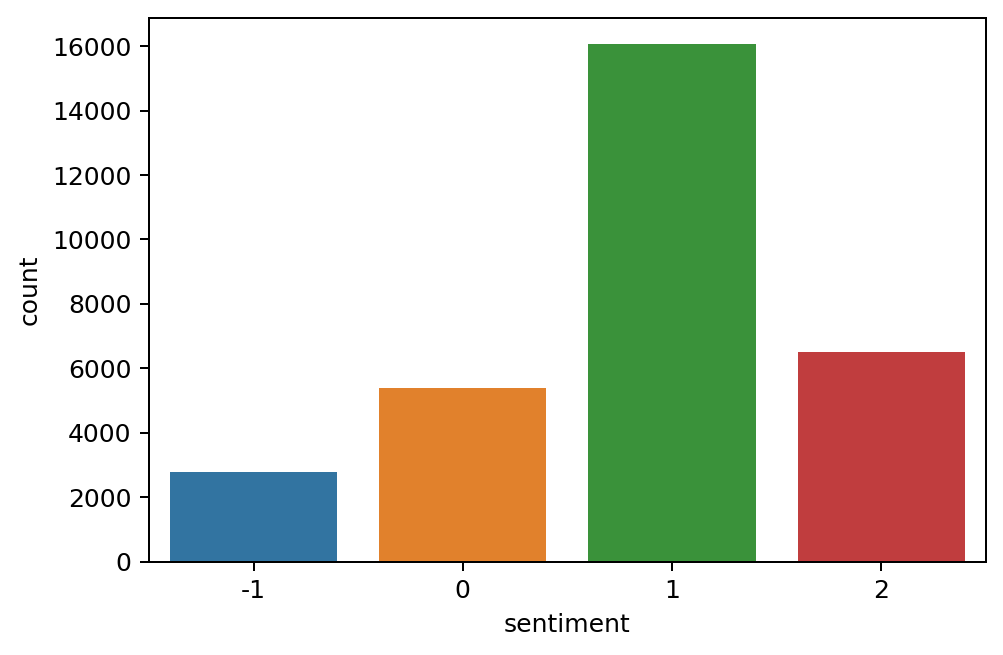

In [15]:
sns.countplot(x = 'sentiment', data = train_df)

***Observations:** 
* This computes the count observations of our predictive (y) variable sentiment.The lenght bar shows the mean value plotted against our predictivive variable 

**Remove duplicate tweets**

In [16]:
#checking the shape of the data
train_df = Trainingdata.drop_duplicates()
train_df.shape

(30759, 3)

In [17]:
train_df.tweetid.unique

<bound method Series.unique of 0        897853122080407553
1        925046776553529344
2        696354236850786305
3        846806509732483072
4        628085266293653504
                ...        
30754    958155326259367937
30755    956048238615900163
30756    800258621485391872
30757    871365767895404545
30758    666236638155141121
Name: tweetid, Length: 30759, dtype: int64>

**Removing emojis**

In [18]:
pip install emoji --upgrade

Requirement already up-to-date: emoji in c:\users\thandokuhlenedbank\anaconda3\lib\site-packages (1.2.0)
Note: you may need to restart the kernel to use updated packages.


In [19]:
import emoji
import string

def remove_emoji(tweet_):
    characters = [str for str in tweet_]
    list_of_emoji = [i for i in characters if i in emoji.UNICODE_EMOJI]
    clean_tweet = ' '.join([str for str in tweet_.split() if not any(j in str for j in list_of_emoji)])
    return clean_tweet

In [20]:
tweets_list = []

for index, rows in train_df['message'].iteritems():
    rows =  remove_emoji(rows)
    tweets_list.append(rows)
    
train_df['message'] = tweets_list

**Remove Line breaks, URL's, Numbers, Capital letters, & Punctuation**

In [21]:
#Remove Line breaks, URL's, Numbers, Capital letters, & Punctuation
import re
import string


def tweet_preprocessor(tweet):
    tweet = tweet.replace('\n', ' ')                           # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet)           # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet)                     # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ',   
            tweet.lower())                                     # remove capital letters and punctuation
    return tweet

In [22]:
for i,row in train_df.iterrows():
    train_df.at[i,'message'] = tweet_preprocessor(row['message'])

In [23]:
train_df

sentiment                                            message  \
0             -1  rt  darreljorstad  funny as hell  canada deman...   
1             -1  all the biggest lies about climate change and ...   
2             -1  the coming revelation of the  q global warming...   
3             -1  rt  dineshdsouza  let s see if the world ends ...   
4             -1  rt  stevesgoddard  obama has no control over t...   
...          ...                                                ...   
30754          2  rt  time  the pentagon warned that climate cha...   
30755          2  study finds that global warming exacerbates re...   
30756          2  rt  mikeyslezak  the global green movement pre...   
30757          2  rt  profedwardsnz  nyc mayor says ny will go f...   
30758          2       rt sanders  climate change causes terrorism    

                  tweetid  
0      897853122080407553  
1      925046776553529344  
2      696354236850786305  
3      846806509732483072  
4      628085266293653504  
...                   ...  
30754  958155326259367937  
30755  956048238615900163  
30756  800258621485391872  
30757  871365767895404545  
30758  666236638155141121  

[30759 rows x 3 columns]

In [24]:
#Tokenization -> chops each tweet into a collection of individual words (i.e. tokens)
#Lemmatization -> Aims to cut each word down to its base form 
                #(e.g. laugh, laughs, laughing, laughed would be reduced to laugh)
                #This reduces the complexity of analysis by reducing number of unique words

In [25]:
# Looking at the numbers of possible classes in our sentiment
Trainingdata['sentiment'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [26]:
# Looking at the how the messages are distributed across the sentiment
Trainingdata.describe()

sentiment       tweetid
count  30759.000000  3.075900e+04
mean       0.853929  8.364330e+17
std        0.853551  8.519986e+16
min       -1.000000  5.926334e+17
25%        0.000000  7.970301e+17
50%        1.000000  8.401516e+17
75%        1.000000  8.996975e+17
max        2.000000  9.666876e+17

## Missing values

In [27]:
# Checking for missing values
Trainingdata.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [28]:
# Checking whether a character is white-space character or not
print(len(Trainingdata['message']))
print(sum(Trainingdata['message'].apply(lambda x: x.isspace())))

30759
0


In [29]:
# Sample tweet
tweet = Trainingdata.iloc[6,1]
print(tweet)

RT @T_S_P_O_O_K_Y: @beardoweird0 @20committee I actually have a degree in Environmental Studies - and yes - man made climate change is a ho…


Text(0.5, 1.0, 'Distribution of target labels')

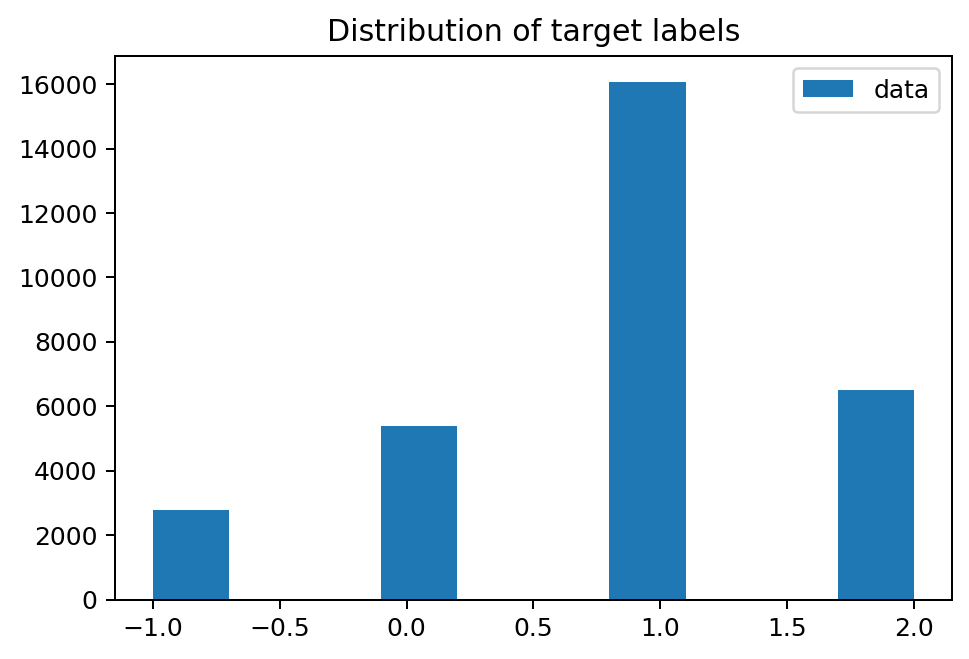

In [30]:
# Visualizing the distribution of the target 
plt.hist(Trainingdata['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

**Observations:**
* There is an imbalance of classes in the daset and which can cause a disproportionate ratio of observations in each class. This can cause inaccurate and erros to our algorithms are designed to maximize accuracy and reduce error. Therefore we will address the imbalance in our EDA.


Text(0, 0.5, 'Density')

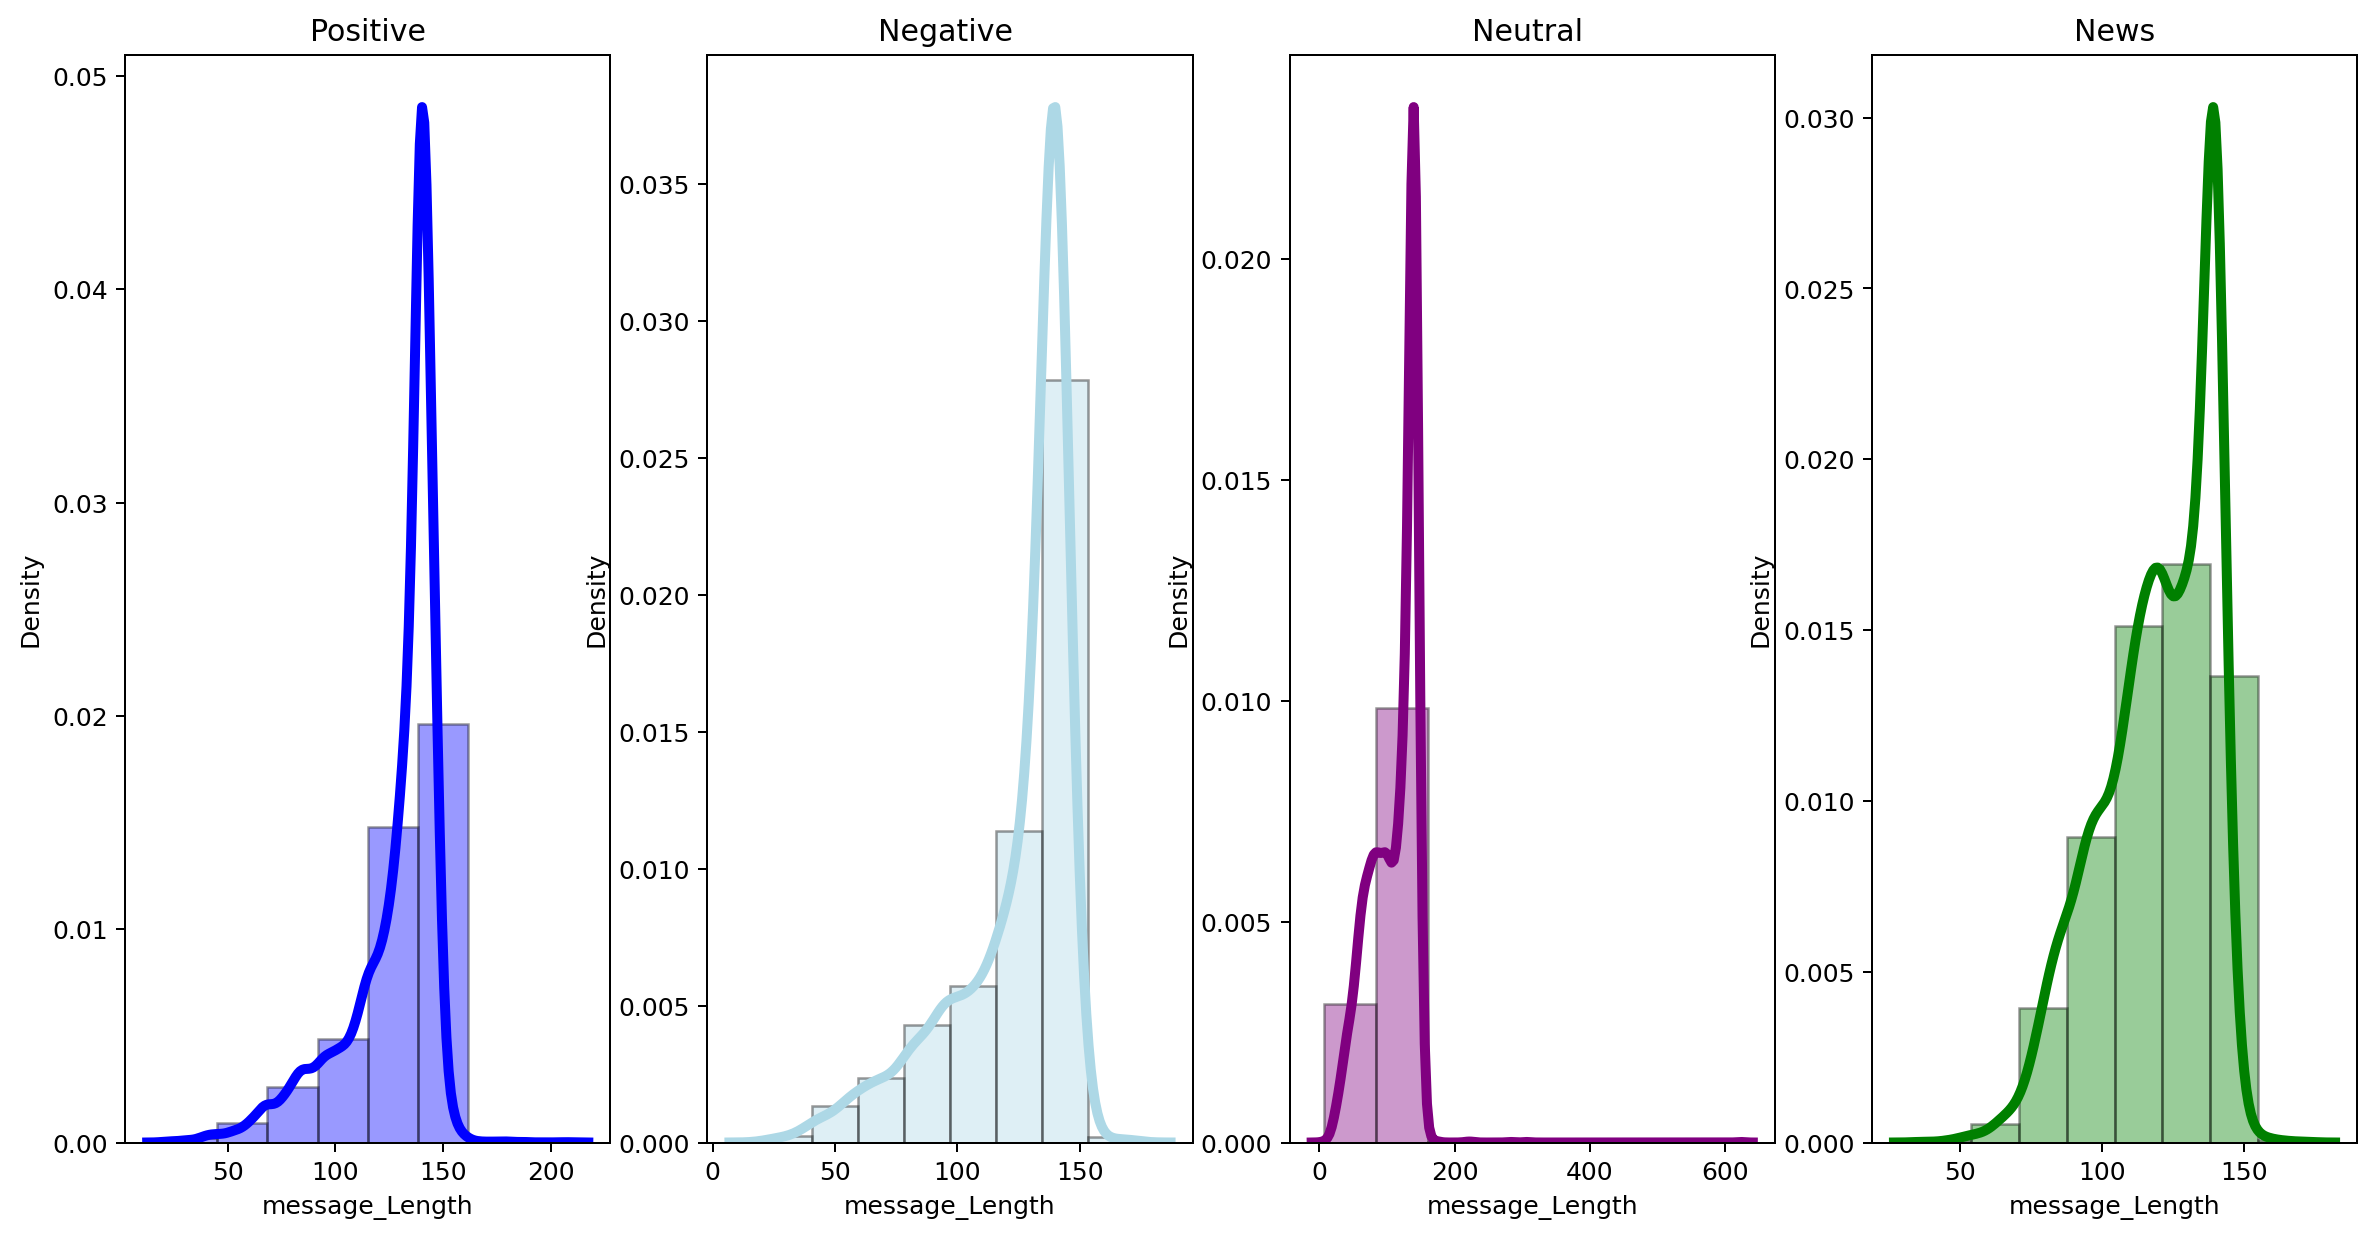

In [31]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(Trainingdata[Trainingdata['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(Trainingdata[Trainingdata['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(Trainingdata[Trainingdata['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(Trainingdata[Trainingdata['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

**Observations:**
* The average length of messages for all sentiments tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting and will make for more unpacking later in the EDA. Now that we have explored our dataset, we can begin perfoming some analyses on it.

# **Exploratory Data Analysis<a id='EDA'></a>**

Exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.This approach for data analysis uses many tools(mainly graphical to maximize insight into a data set, extract important variables, detect outliers and anomalies, amongst other details that is missed when looking at DataFrame.

This step is very important especially when we model the data in order to apply Machine Learning techniques.

In [32]:
working_df = Trainingdata.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

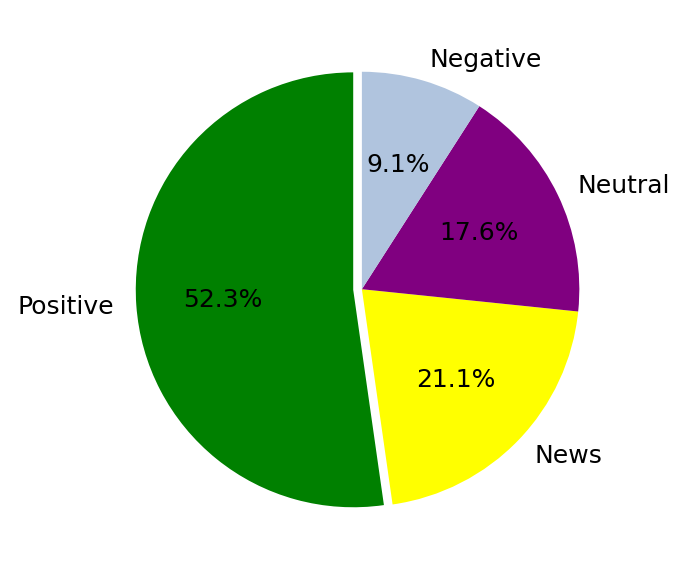

In [33]:
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['green', 'yellow', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

**Observations:**
* There are more than 15000 entries in our dataset. Above is the count and distribution of our respective sentiments. Since our dataset contains no missing values, we consider this count accurate. According to this class distribution, the data is skewed towards the positive comments represented by by number 1 , and takes 52,3% of the count.


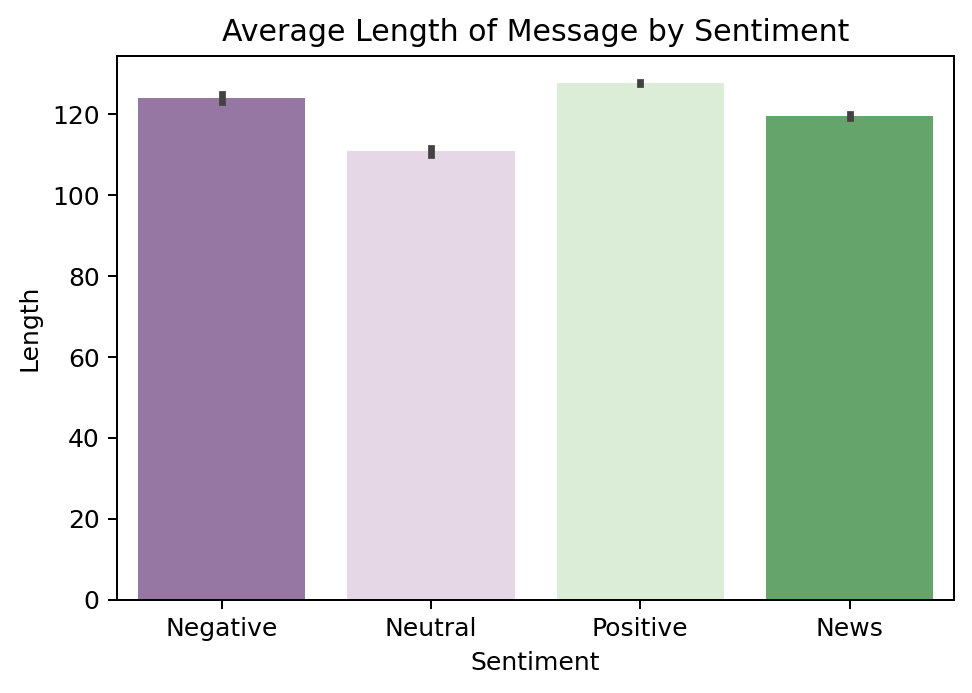

In [34]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

**Observations:**
* The number of messages per sentiment and it can be seen that the data is almost evenly distributed, as opposed to the sentiments themselves shown above.

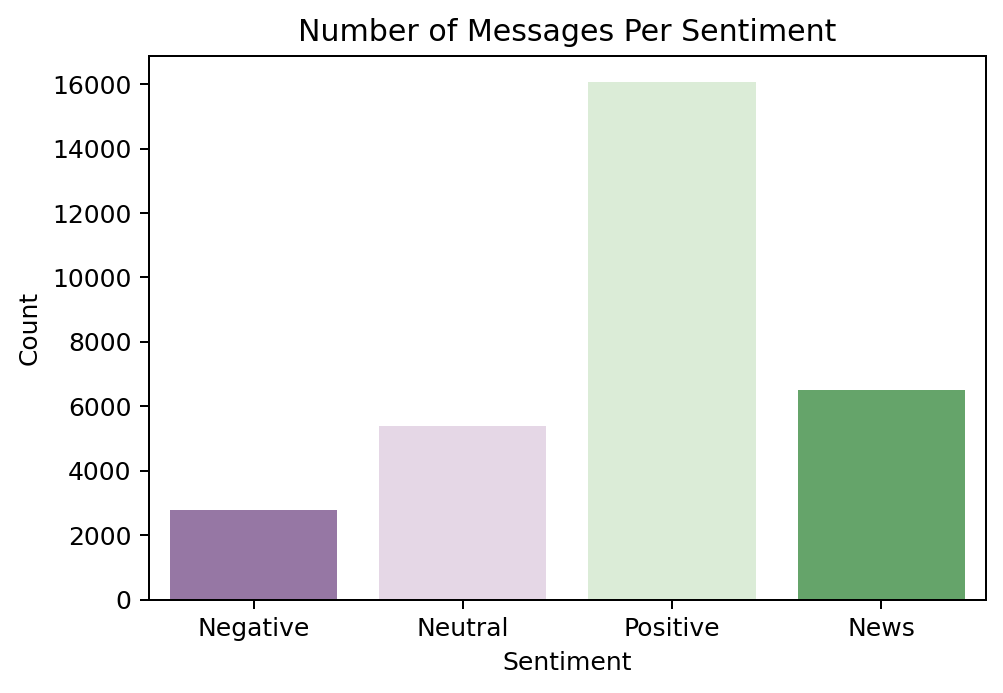

In [35]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

**Observations:**
* The sum of the tweets relating to news,neutral and negative is less than half of the total tweets.
* Looking at the distribution we are able to see that the data is imbalanced, most tweets are skewed to the Pro sentiment category supporting the belief of man-made climate change.

In [36]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in working_df.message]

# Creating a column of hastags
working_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in working_df.message]

In [37]:
# Generating Counts of users
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [38]:
# Top 5 most popular
counts.head()

users  message
6286   @StephenSchlegel      362
6010        @SenSanders      312
11491  @realDonaldTrump      217
12324          @thehill      161
804      @BernieSanders      152

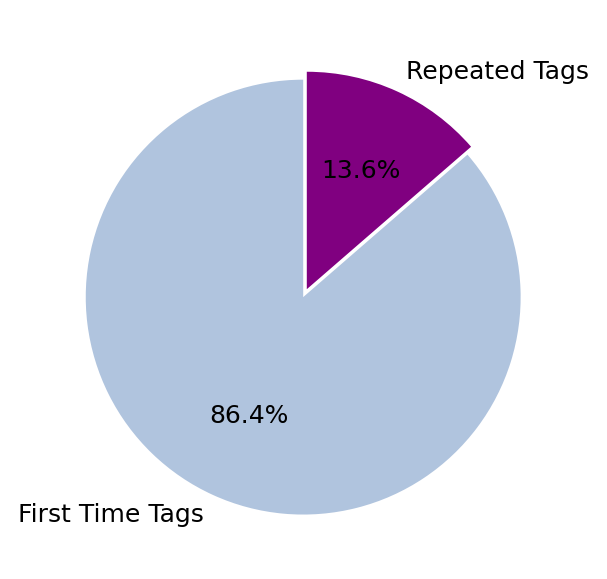

In [39]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['lightsteelblue', "purple"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

**Observations:**
* Here we have the numerical distribution of all repeated and first time hashtags across the messages. As it can be seen the first time hashtags are leading with more than 80% of the total.

In [40]:
repeated_tags_rate = round(sum(np.array(counts['message']) > 1)*100/len(counts['message']), 1)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

13.6 percent of the data are from repeated tags


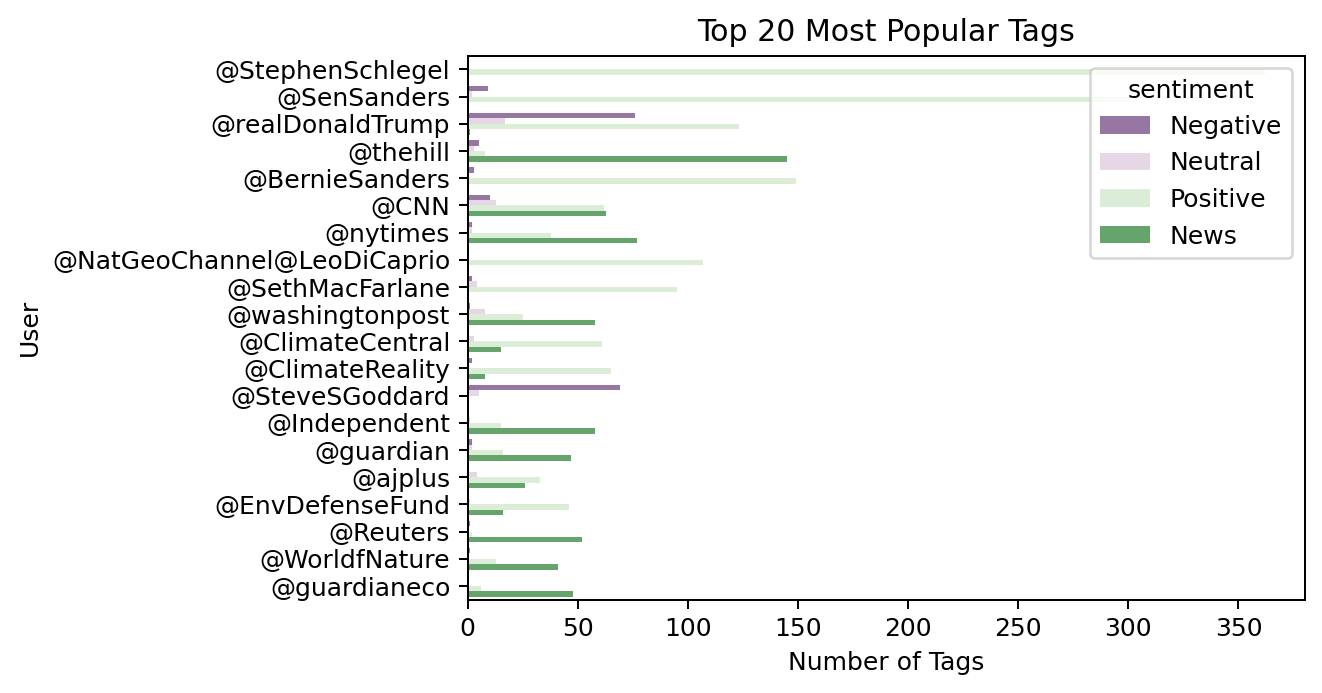

In [41]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df, palette='PRGn',
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

**Observations:**
* Now that we have had a look at the tweets themselves as well as the users,we now analyse the hashtags of each sentiment. In each visualization of the individual hashtags, only 20 will be displayed.
* We can see that the top 5hashtags have similar words like Climate change, The Hill, Donald Trump and Bernie Sanders.
* It is important to note that Bernie Sanders’s had aggressive climate strategy on his Presidential campaign. 

### Extracting hashtags


* People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag. Hashtags can be included anywhere in a Tweet

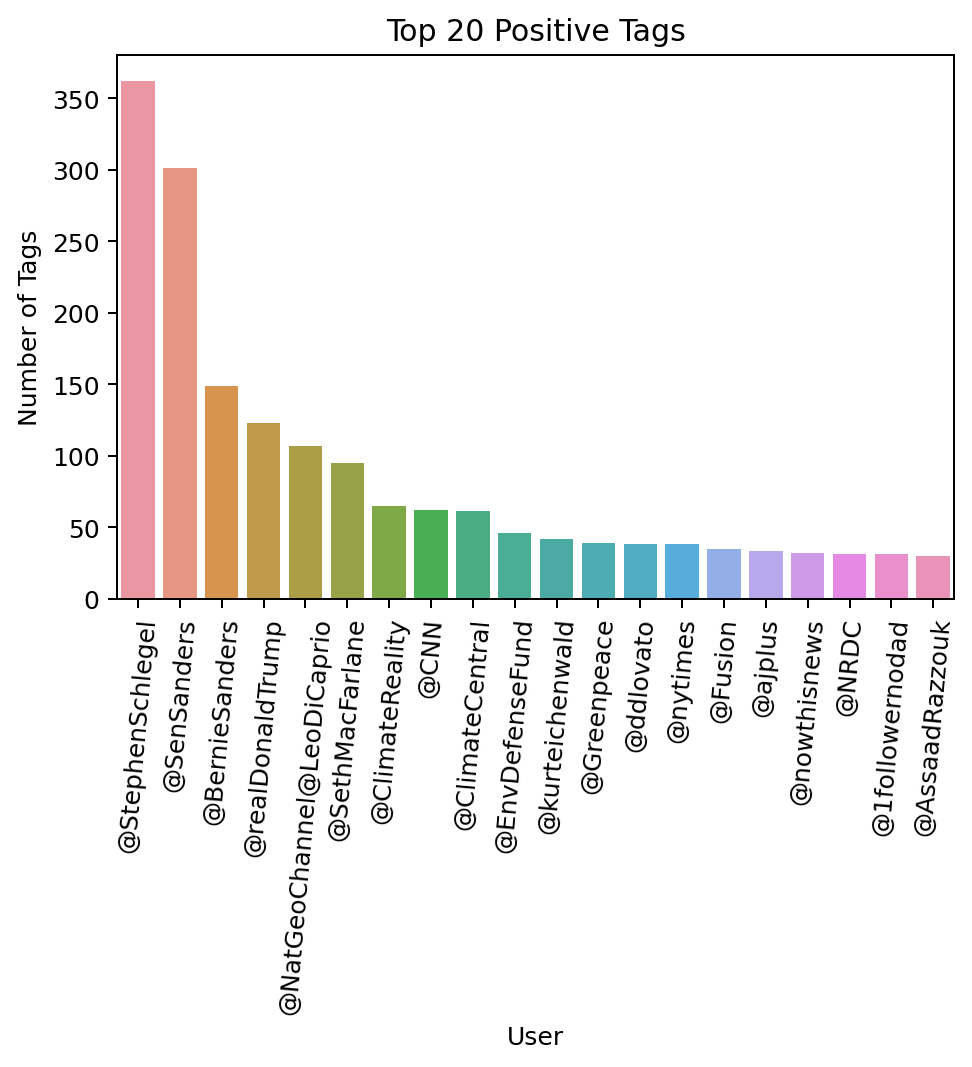

In [42]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Positive'],
              order=working_df[working_df['sentiment'] == 'Positive'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Positive Tags')
plt.xticks(rotation=85)
plt.show()

**Observations**
* We can see that the top 5 hashtags have similar words like climate, stephen schlegel, sen Sanders,Bernie Sanders,and Donal Trump.
* Sanders’s Climate Ambitions Thrilled Supporters and resulted in him having the most mentions in positive climate change tweets.
* The actor Leonardo DiCaprio is amogst the most popular positive hastags in climate change tweets, this refers to a 2016 documentary where actor Leonardo DiCaprio meets with scientists, activists and world leaders to discuss the dangers of climate change and possible solutions.


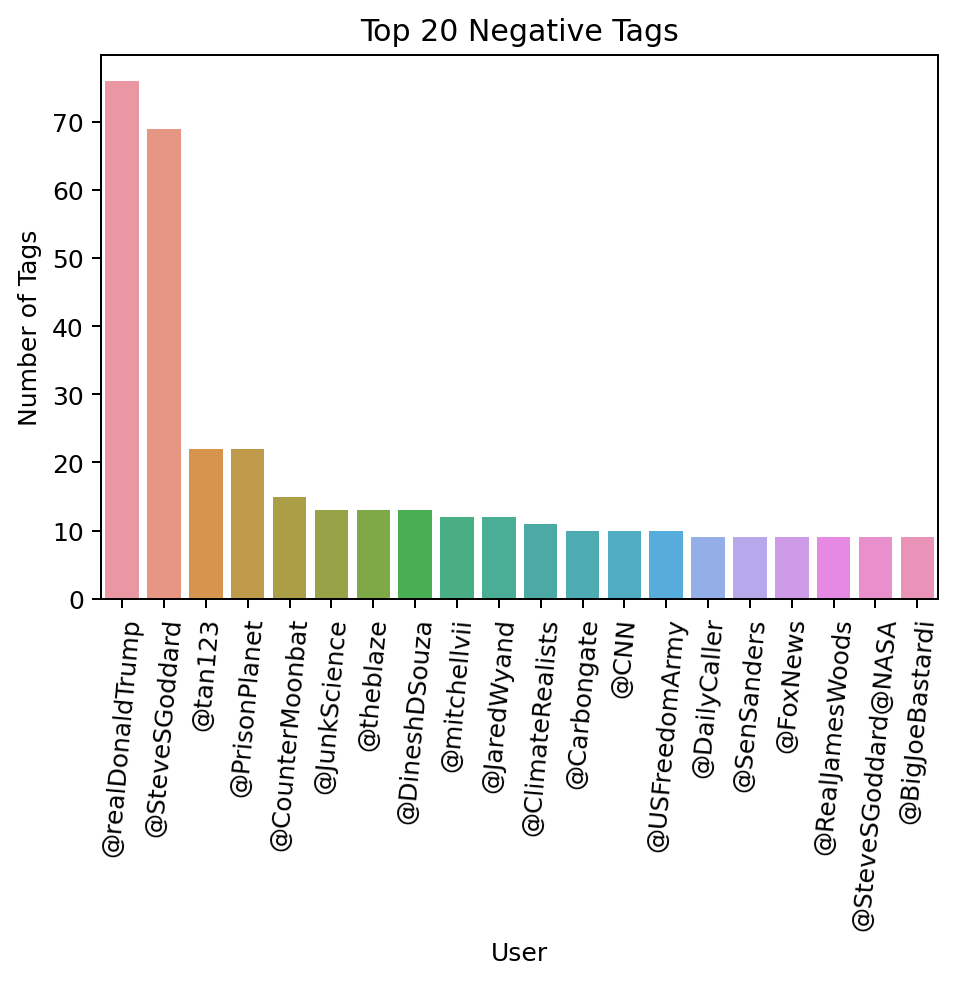

In [43]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

**Observations**
* In the negative climate change, Donald Trump is the top popular hashtag .
* The fomer president of the US, Donald Trump at a campaign rally in Minden, Nevada, mocked climate change and pushed policies that accelerate it, leaving the United States treading water on climate change action in the past four years.
* This soon became a trending hashtag to use to show support for Donald Trump




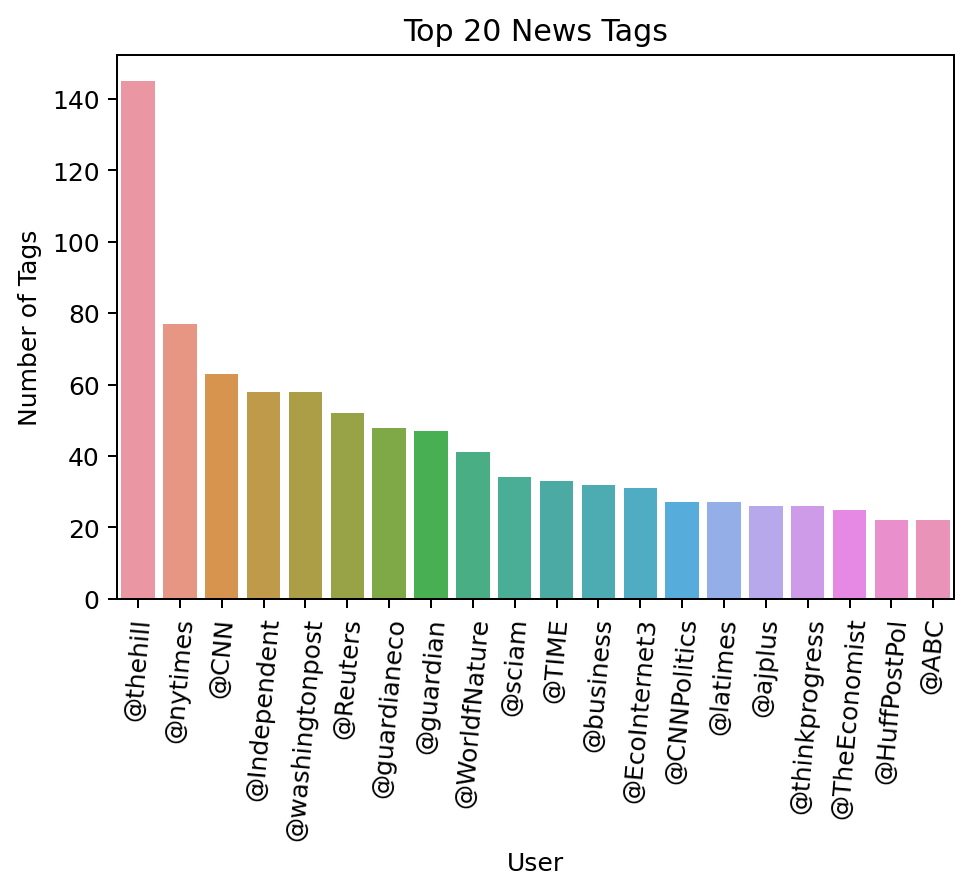

In [45]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'News'],
              order=working_df[working_df['sentiment'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

**Observations**

* The The Hill news channel seems to be have the most mentions in the top 20 news tags.
* The Hill news house reported on the thousands protest in French cities in fight against climate change,hecne they had the most popular mentions on the news hash tags.
* The positive and neutral setiments seem to have the most mentions in the tweets compared to the news and negative sentiment classes.





## Word Clouds
#### A word cloud is a visual word aggregation (cloud) filled with words in different sizes and colours, which represent the frequency or the importance of each word

In [46]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [47]:
from wordcloud import WordCloud

In [48]:
working_df['sentiment']

0        Negative
1        Negative
2        Negative
3        Negative
4        Negative
           ...   
30754        News
30755        News
30756        News
30757        News
30758        News
Name: sentiment, Length: 30759, dtype: object

In [49]:
#Words in the positve class
positive_words =' '.join([text for text in working_df['message'][working_df['sentiment'] == 'Positive']]) 
#Words in negative class
negative_words = ' '.join([text for text in working_df['message'][working_df['sentiment'] == 'Negative']]) 
#Words in neutral class 
neutral_words =' '.join([text for text in working_df['message'][working_df['sentiment'] == 'Neutral']]) 
#Words in the news class
news_words =' '.join([text for text in working_df['message'][working_df['sentiment'] == 'News']]) 

In [50]:
#Function used to creat word cloud visualisation from text data
def word_cloud(class_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,colormap='tab20c').generate(class_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Most Common Words In Class")
    plt.axis('off')
    return plt.show()

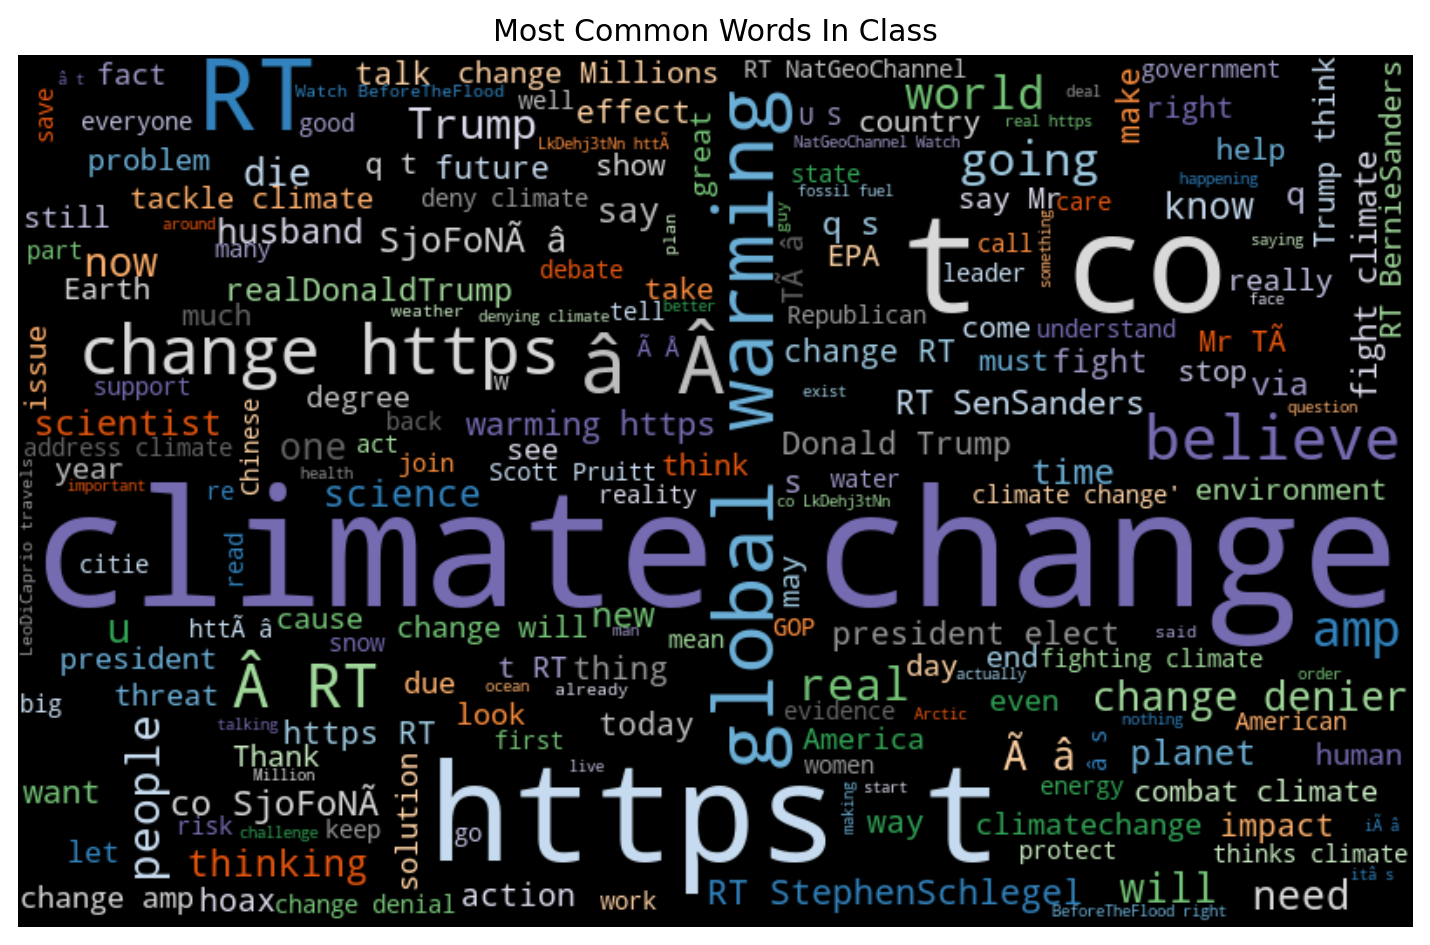

In [51]:
#Visualise all words from the respective classes
word_cloud(positive_words)


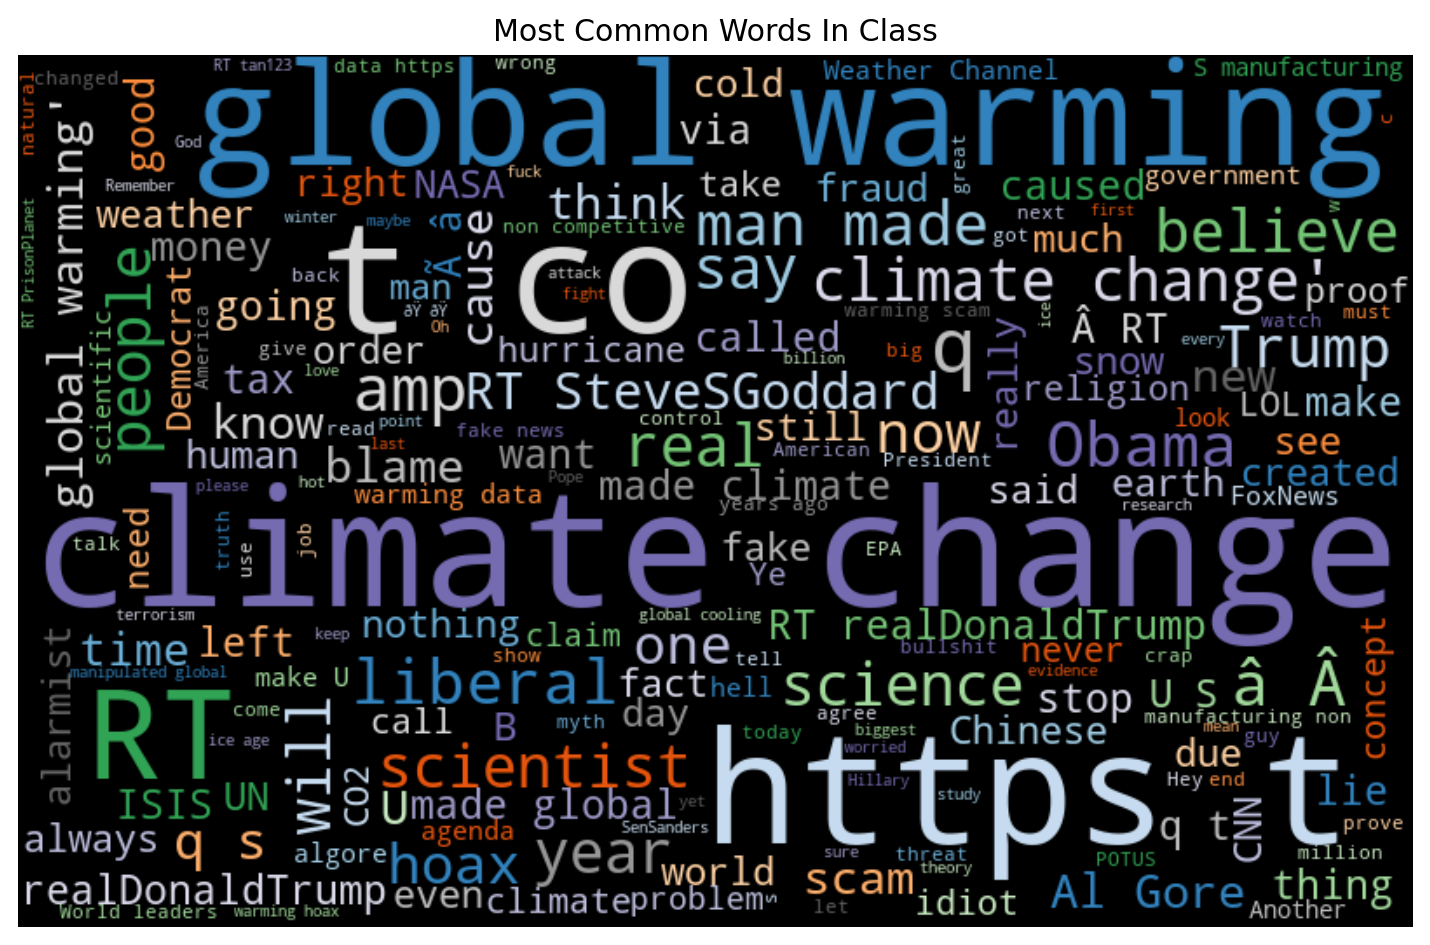

In [52]:
word_cloud(negative_words)


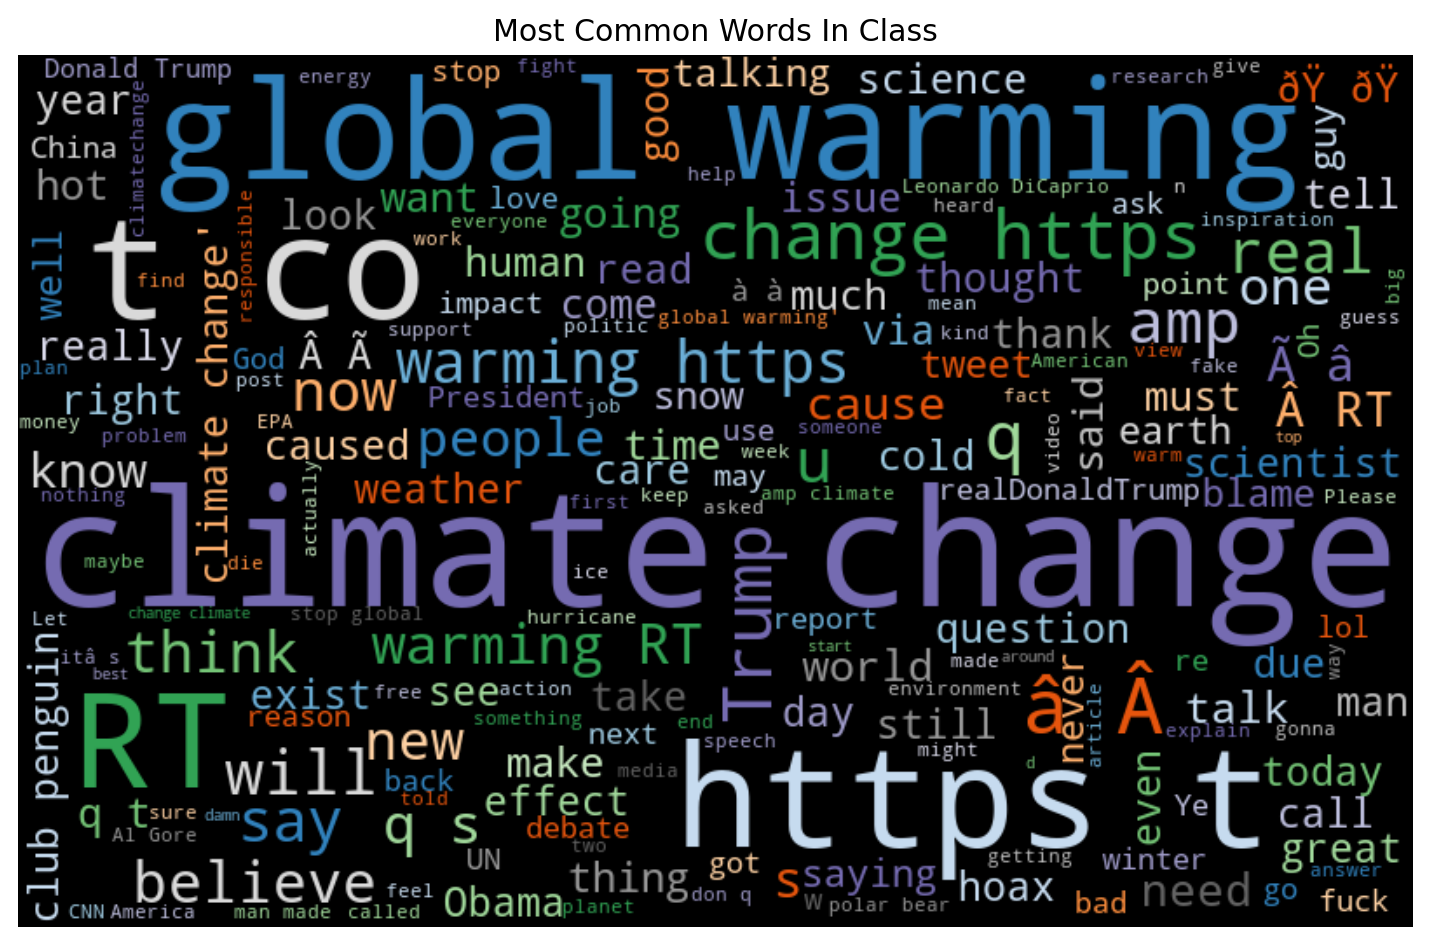

In [53]:
word_cloud(neutral_words)


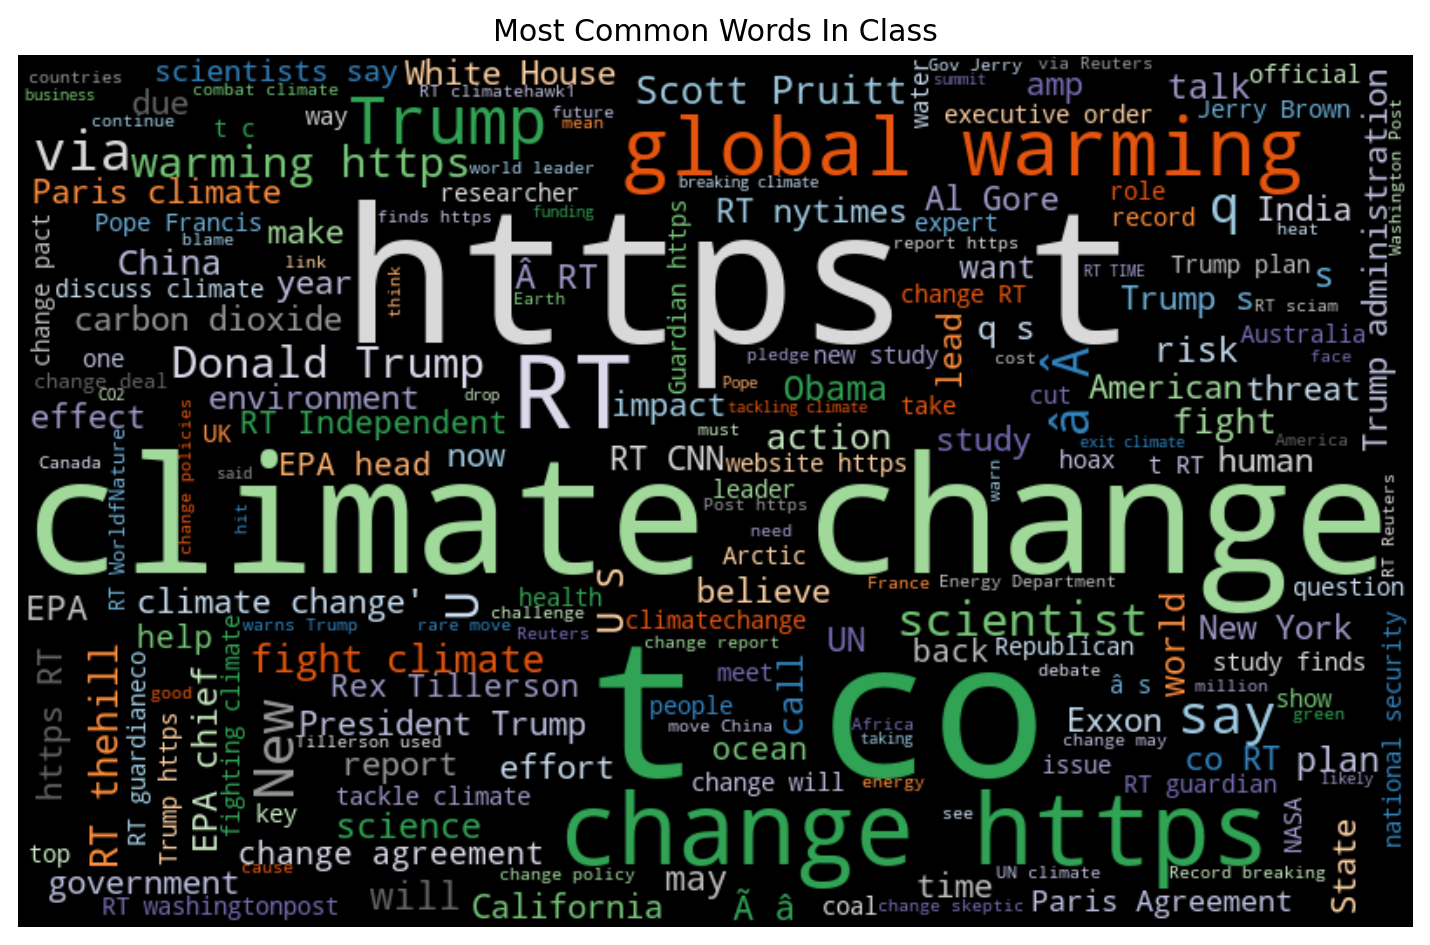

In [54]:
word_cloud(news_words)

**Observations:**

* The size of the word indicates the relevance in the tweet.
* The most popular words in all four classes are climate change, global warming and belief.
* The pro and anti groups include a number of words that might be expected in each group.

* In the word clouds there is evidence of noisy text which include words such as https, webside, co and RT. These do not assist us in our classification, rather they add noise, we will have another look at it when the noise have been removed.
* https occurs frequently in pro climate change tweets, implying that many links are being shared around the topic of climate change. These could be links to petitions, websites and/or articles related to climate change. Interesting to note: https only occurs in the top 25 words for the pro climate change class. Why aren't we seeing more links in the news class?

# **Model Building**

In [55]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# NLP Libraries
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import pickle

### Data preprocessing<a id='Preprocessing'></a>

In [56]:
def data_preprocessing(df):
    lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    stopWords = set(stopwords.words('english'))
    
    for tweet in df['message']:
        
        onlyWords = re.sub('[^a-zA-Z]', ' ', tweet)     #keeping only words
        url = re.compile(r'https?://\S+|www\.\S+')      #removing URLs
        review_ = url.sub(r'',onlyWords)
        html=re.compile(r'<.*?>')
        review_ = html.sub(r'',review_)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"     # emoticons
                           u"\U0001F300-\U0001F5FF"     # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"     # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"     # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        review_ = emojis.sub(r'',review_)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review_)
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stopWords]
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        
    return df

In [57]:
# Preprocessing the data
train_df = data_preprocessing(train_df)
test_df = data_preprocessing(test_df)

In [58]:
train_df

sentiment                                            message  \
0             -1  rt  darreljorstad  funny as hell  canada deman...   
1             -1  all the biggest lies about climate change and ...   
2             -1  the coming revelation of the  q global warming...   
3             -1  rt  dineshdsouza  let s see if the world ends ...   
4             -1  rt  stevesgoddard  obama has no control over t...   
...          ...                                                ...   
30754          2  rt  time  the pentagon warned that climate cha...   
30755          2  study finds that global warming exacerbates re...   
30756          2  rt  mikeyslezak  the global green movement pre...   
30757          2  rt  profedwardsnz  nyc mayor says ny will go f...   
30758          2       rt sanders  climate change causes terrorism    

                  tweetid                                       tweet tokens  
0      897853122080407553  [rt, darreljorstad, funny, hell, canada, deman...  
1      925046776553529344  [biggest, lie, climate, change, global, warmin...  
2      696354236850786305  [coming, revelation, q, global, warming, q, fr...  
3      846806509732483072  [rt, dineshdsouza, let, see, world, end, reald...  
4      628085266293653504  [rt, stevesgoddard, obama, control, climate, w...  
...                   ...                                                ...  
30754  958155326259367937  [rt, time, pentagon, warned, climate, change, ...  
30755  956048238615900163  [study, find, global, warming, exacerbates, re...  
30756  800258621485391872  [rt, mikeyslezak, global, green, movement, pre...  
30757  871365767895404545  [rt, profedwardsnz, nyc, mayor, say, ny, go, f...  
30758  666236638155141121    [rt, sander, climate, change, cause, terrorism]  

[30759 rows x 4 columns]

In [59]:
#features and the label
X = train_df['tweet tokens']
y = train_df['sentiment']

In [60]:
# Tranforming the dataset
data = train_df['tweet tokens']
corpus = [' '.join(i) for i in data] #create your corpus here
vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
X = vectorizer.fit_transform(corpus)

In [61]:
X

<30759x32328 sparse matrix of type '<class 'numpy.float64'>'
	with 336550 stored elements in Compressed Sparse Row format>

## Logistic Regression

This a type of regression that uses an S-shaped curve called Sigmoid to squeeze the range of output values to exist only between 0 and 1.
It has a point of inflection, which can be used to separate the feature space into two distinct areas (one for each class).
It has shallow gradients at both its top and bottom, which can be mapped to zeroes or ones respectively with little ambiguity.

In [62]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scikit_log_reg = LogisticRegression(solver='liblinear',random_state=42)
LogisticRegression_model=scikit_log_reg.fit(X_train, y_train)

In [63]:
# Predictions
y_pred = LogisticRegression_model.predict(X_test)

In [64]:
# Evaluating the Logistic Regression model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 168   85  238   25]
 [  18  369  644   64]
 [  16   90 2956  192]
 [   6   29  465  787]]
              precision    recall  f1-score   support

          -1       0.81      0.33      0.46       516
           0       0.64      0.34      0.44      1095
           1       0.69      0.91      0.78      3254
           2       0.74      0.61      0.67      1287

    accuracy                           0.70      6152
   macro avg       0.72      0.55      0.59      6152
weighted avg       0.70      0.70      0.67      6152



In [65]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [66]:
pred = LogisticRegression_model.predict(tests_X)
predictions = pred[:]

In [67]:
len(list(predictions))

10546

In [68]:
len(test_df['tweetid'].to_list())

10546

In [69]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions)
    })
submission.to_csv("LogisticRegressionSubmissions.csv", index=False)

In [70]:
#saving model as dump
with open('logisticRegression.pkl', 'wb') as file:
    pickle.dump(LogisticRegression_model,file)

## DecisionTreeClassifier

Decision tree is a non-parametric method for both classification and regression.It breaks down datasets into smaller subsets, while a decision tree structure is formed.The end result is a tree with decision nodes and leaf nodes.A decision node has two or more branches, each representing values for the attribute tested

### Model Training

In [71]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
decisionTree_model = clf.fit(X_train,y_train)

### Model Prediction

In [72]:
# Predictions
y_pred = decisionTree_model.predict(X_test)

### Model Performance

In [73]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 150   85  241   40]
 [  64  400  532   99]
 [ 122  362 2426  344]
 [  41  107  462  677]]
              precision    recall  f1-score   support

          -1       0.40      0.29      0.34       516
           0       0.42      0.37      0.39      1095
           1       0.66      0.75      0.70      3254
           2       0.58      0.53      0.55      1287

    accuracy                           0.59      6152
   macro avg       0.52      0.48      0.50      6152
weighted avg       0.58      0.59      0.58      6152



In [74]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [75]:
pred = decisionTree_model.predict(tests_X)
predictions_DT = pred[:]

In [76]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_DT)
    })
submission.to_csv("DecisionTreeClassifierSubmission.csv", index=False)

In [77]:
#saving model as dump
with open('DecisionTreeClassifier.pkl', 'wb') as file:
    pickle.dump(decisionTree_model,file)

## SVM Classifier

This classifier separates data points using a hyperplane with the largest amount of margin. That's why an SVM classifier is also known as a discriminative classifier. SVM finds an optimal hyperplane which helps in classifying new data points. SVM Classifiers offer good accuracy and perform faster prediction

### Model Training

In [78]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(kernel='linear') # Linear Kernel
SVM_model = clf.fit(X_train, y_train)

### Model Prediction

In [79]:
# Predictions
y_pred = SVM_model.predict(X_test)

### Model Performance

In [80]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 239   85  173   19]
 [  45  441  535   74]
 [  40  148 2832  234]
 [  12   51  356  868]]
              precision    recall  f1-score   support

          -1       0.71      0.46      0.56       516
           0       0.61      0.40      0.48      1095
           1       0.73      0.87      0.79      3254
           2       0.73      0.67      0.70      1287

    accuracy                           0.71      6152
   macro avg       0.69      0.60      0.63      6152
weighted avg       0.70      0.71      0.70      6152



### Model Testing

In [81]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [82]:
pred = SVM_model.predict(tests_X)
predictions_SVM = pred[:]

In [83]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_SVM)
    })
submission.to_csv("LinearSVM_Submission.csv", index=False)

In [84]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)#saving model as dump
with open('LinearSVM.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

## GaussianNB

An implemenation of one of the Naive bayes methods.It is suitable to features that follow normal distribution

### Model Training

In [92]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GaussianNB()
X_train = X_train.todense()
GaussianNB_model = model.fit(X_train, y_train)

MemoryError: Unable to allocate 5.93 GiB for an array with shape (24607, 32328) and data type float64

### Model Prediction

In [87]:
# Predictions
X_test = X_test.todense()
y_pred = GaussianNB_model.predict(X_test)

NameError: name 'GaussianNB_model' is not defined

### Model Performance

In [88]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 239   85  173   19]
 [  45  441  535   74]
 [  40  148 2832  234]
 [  12   51  356  868]]
              precision    recall  f1-score   support

          -1       0.71      0.46      0.56       516
           0       0.61      0.40      0.48      1095
           1       0.73      0.87      0.79      3254
           2       0.73      0.67      0.70      1287

    accuracy                           0.71      6152
   macro avg       0.69      0.60      0.63      6152
weighted avg       0.70      0.71      0.70      6152



### Model Testing

In [89]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [90]:
tests_X = tests_X.todense()
pred = GaussianNB_model.predict(tests_X)
predictions_GaussianNB = pred[:]

MemoryError: Unable to allocate 2.54 GiB for an array with shape (10546, 32328) and data type float64

In [91]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_GaussianNB)
    })
submission.to_csv("GaussianNB_Submission.csv", index=False)

NameError: name 'predictions_GaussianNB' is not defined

In [ ]:
#saving model as dump
with open('GaussianNB.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

### Observations

**Observations:**
* From the performance metrics, we see that the **SVM Classifier** and **GaussianNB** models the best on our training, closely followed by the . 
* The Decission tree performes relatively worst, . To ensure that we get a robust measure of classifier performance, we can apply cross validation and hyperparameter tuning on the top performing models.

# **Model Deployment**

# **Conclusion**

The use of social media platforms such as Twitter has played a important role in capturing public opinion for various topics which is vital for different organisations. Classifying the sentiments of tweets which pertains to climate change sheds light to different topics and issues associated with climate change. It also allows one to get a grasp of the main concerns of the public. Organisations can gain powerful insights for marketing purposes by using social media & sentiment analysis.

Impact investing is an emerging field that refers to investments made into companies and organisations with the intention to generate measurable social or environmental impact alongside financial return.Our model provides a valuable solution to this problem and can add to their market research efforts in gauging how their product or service may be received. It gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories, thus increasing their insights and informing future marketing strategies.

Based on the findings, the best performing models were the **SVM Classifier** and **GaussianNB**. This model can be used by interested companies to evaluate their clients sentiments towards global warming. 


# **References** 

1. Comet Starter Notebook: 
https://athena.explore-datascience.net/student/content/pre-processing-view/38/100/1772


2. Explore Data Science trains
https://athena.explore-datascience.net/student/content/all/60/123/3


3. Explore  Data Science Academy pre-precessing material
https://athena.explore-datascience.net/student/content/all/60/123/3


4. Building a Twitter Sentiment-Analysis App Using Streamlit
https://medium.com/analytics-vidhya/building-a-twitter-sentiment-analysis-app-using-streamlit-d16e9f5591f8

5. Comprehensive Hands on Guide to Twitter Sentiment Analysis with dataset and code
https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

6. 10 OF THE BEST TWEETS ON CLIMATE CHANGE 
https://www.climaterealityproject.org/blog/10-best-tweets-climate-change

7. Media Bias Detection using Deep Learning Libraries in Python
https://towardsdatascience.com/media-bias-detection-using-deep-learning-libraries-in-python-44efef4918d1

8. Does it make sense to use both countvectorizer and tfidfvectorizer as feature vectors for text clustering with KMeans?
https://stackoverflow.com/questions/27496014/does-it-make-sense-to-use-both-countvectorizer-and-tfidfvectorizer-as-feature-ve

9. Reccurent Neural Networks (RNN), the following video from MIT is an excellent resource:
https://www.youtube.com/watch?v=SEnXr6v2ifU

10. Cross Validation and Grid Search for Model Selection in Python
https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/



